### Single-cell RNA transcriptomics cell clustering

This notebook is an introductory guide to single-cell RNA-seq analysis. It makes use of a canned dataset from Python's `scanpy` package, as well as `AnnData` objects: the quintissential container for annotated matrices like scRNA-seq data.

It demonstrates foundational analysis methods like EDA, PCA and statistical gene ranking.

Note that the analysis here is not biologically sound and would require a much larger dataset along with functional validation to derive any meaningful insight. This is only intended to serve educational purposes.

Let's first import dependecies and load our data. We'll be working with a dataset of 3,000 PBMCs from `scanpy`.

In [2]:
import scanpy as sc
import matplotlib.pyplot as plt
import leidenalg
import ipykernel
import igraph
import numpy as np



adata = sc.datasets.pbmc3k()
adata.raw = adata # always keep the raw data


/Users/aneesavalentine/tms/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 5.58M/5.58M [00:01<00:00, 4.61MB/s]


In [3]:
# Annotate mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")  # works for human data

# Calculate QC metrics
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt"],
    percent_top=None,
    log1p=False,
    inplace=True
)


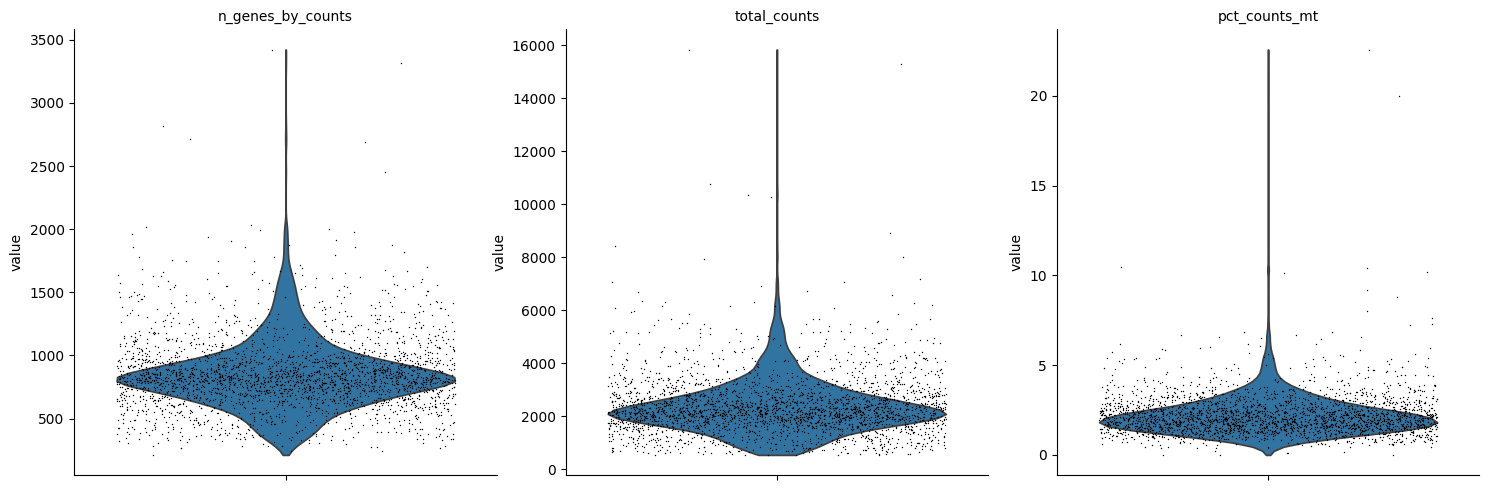

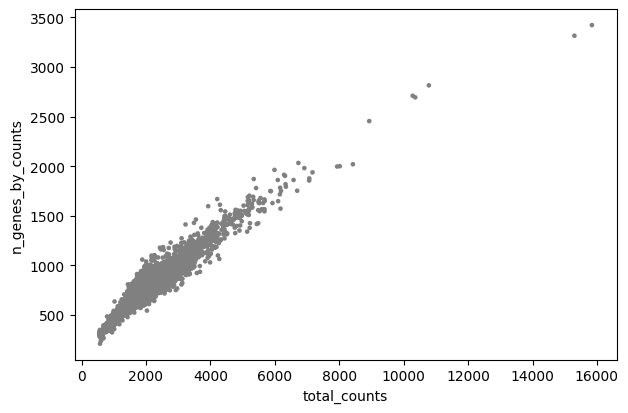

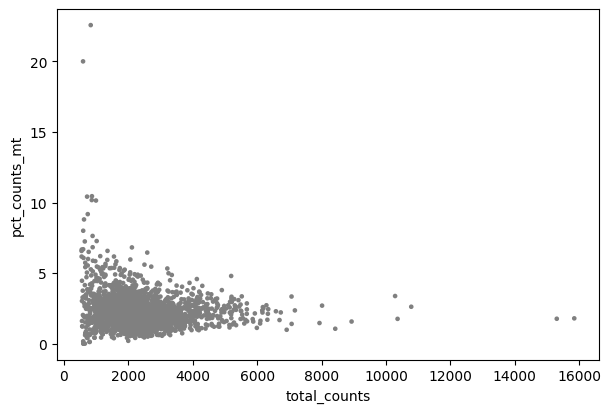

In [4]:
# Plot number of genes per cell
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
             jitter=0.4, multi_panel=True)

# Optional: scatter for relationships
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")


Now we'll execute perhaps the most crucial step of any analysis: EDA.

In [5]:
adata = adata[adata.obs.n_genes_by_counts > 200, :]
adata = adata[adata.obs.n_genes_by_counts < 2000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [6]:
# Normalize total counts per cell to 10,000
sc.pp.normalize_total(adata, target_sum=1e4)

# Log-transform the normalized data
sc.pp.log1p(adata)

# Identify highly variable genes (keep only those)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

# Scale each gene to unit variance and zero mean, clip extreme values to ±10
sc.pp.scale(adata, max_value=10)


/Users/aneesavalentine/tms/lib/python3.13/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/aneesavalentine/tms/lib/python3.13/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/functools.py:931: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [7]:
# perform PCA
sc.tl.pca(adata, svd_solver='arpack')

# set nearest neighbors and compute UMAP
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

/var/folders/bd/djhgjhzs6rx_1ffvlb2ncd8c0000gn/T/ipykernel_12963/3326479127.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


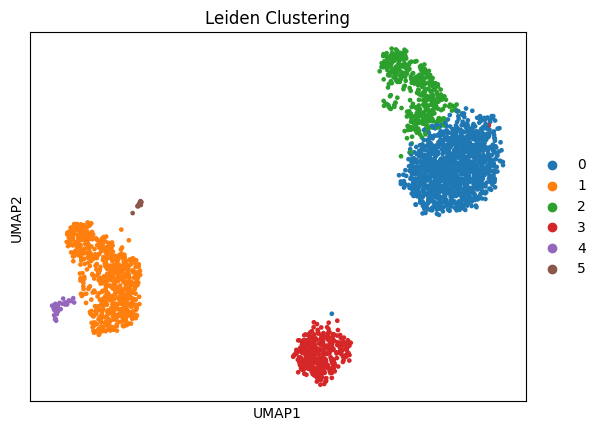

In [ ]:
# perform leiden clustering
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=['leiden'], title='Leiden Clustering')

How would you interpret this plot?

Though PCA clusters cell populations, it doesn't tell us what cell types we're looking at. Let's rank the genes in each cluster to help us identify cell populations.

In [9]:
# reassign adata.raw for gene rank
adata.raw = adata

/Users/aneesavalentine/tms/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/aneesavalentine/tms/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/aneesavalentine/tms/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/aneesavalentine/tms/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/aneesavalentine/tms/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


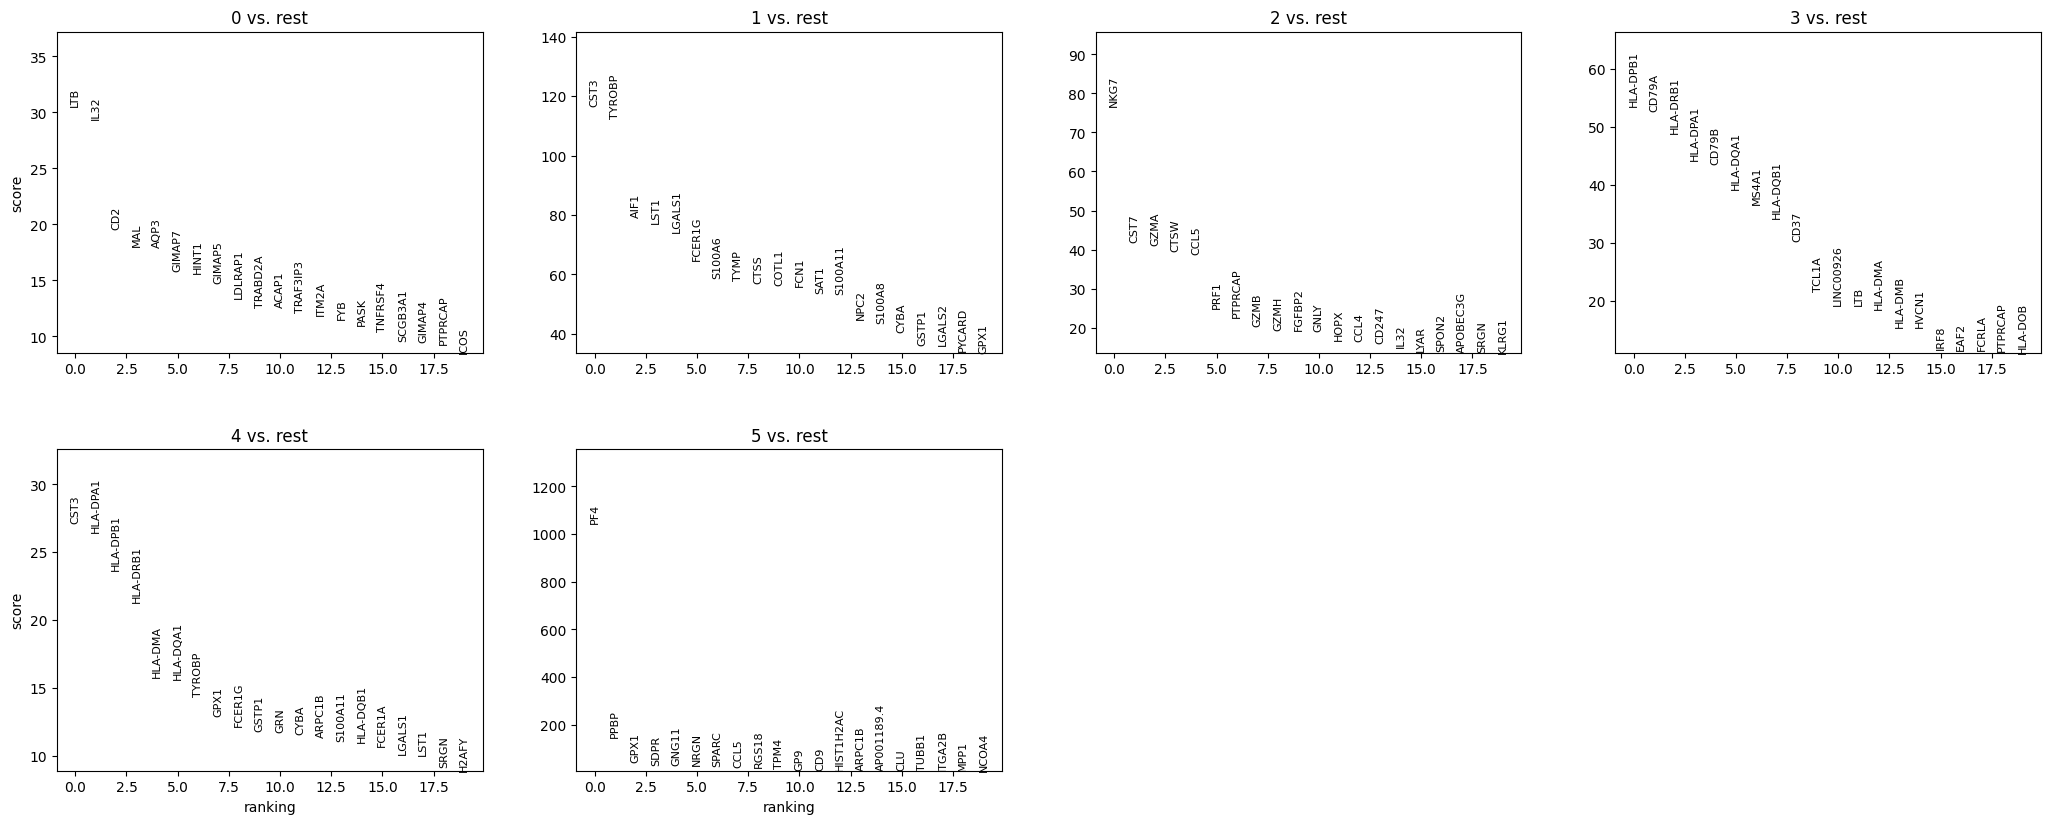

In [10]:
# rank genes in each cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)


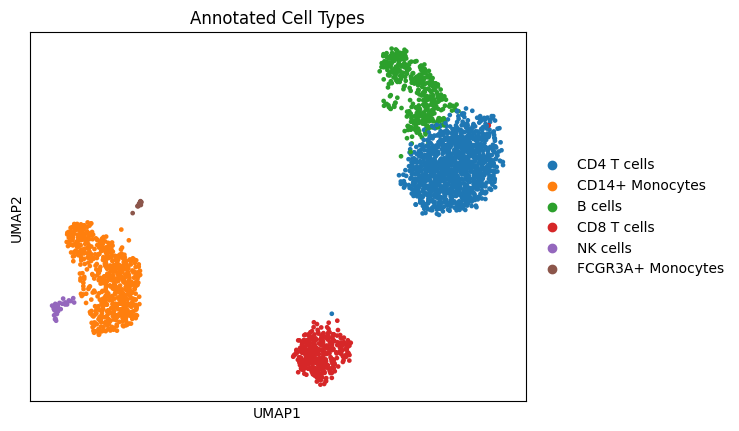

In [11]:
# optional: manually annotate clusters (using canonical markers)
cluster_annotations = {
    '0': 'CD4 T cells',
    '1': 'CD14+ Monocytes',
    '2': 'B cells',
    '3': 'CD8 T cells',
    '4': 'NK cells',
    '5': 'FCGR3A+ Monocytes',
    '6': 'Dendritic cells',
    '7': 'Megakaryocytes',
}

adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_annotations)
sc.pl.umap(adata, color=['cell_type'], title='Annotated Cell Types')
